In [ ]:
# Install dependencies
! pip install -q -U neptune_scale torch datasets

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
from datasets import load_dataset

import matplotlib.pyplot as plt

from neptune_scale import Run

In [ ]:
# TODO - capture the folowings; attentions, learning rate (per layer if needed)
    # complete - activations, grad norms, gradients - weights+biases, loss - agg
# TODO - capture per layer losses
# TODO - increase number of layers
# TODO - Adding dropout to demonstrate the effects of regularization
# TODO - batch normalization

During training, capturing valuable information from each layer of a model can provide insights into how the model is learning, what features are being extracted, and how the model's performance can be improved. Researchers often look for certain metrics and activations from each layer, which can help in diagnosing issues such as vanishing gradients, overfitting, or underfitting.

Key Information to Capture from Each Layer:
Activations:

What it shows: The activations of each layer during forward propagation can give insights into how the model is processing input data at different levels. By examining activations, you can see if certain layers are "dead" (i.e., not learning anything) or if activations are exploding (leading to unstable training).
How to capture: You can register hooks to capture activations after each layer.
Gradients:

What it shows: The gradients of each layer during backpropagation are important for diagnosing issues like vanishing or exploding gradients. If gradients are too small, it can indicate the model is struggling to learn effectively (vanishing gradients). If they're too large, it can indicate instability (exploding gradients).
How to capture: Similar to activations, you can use hooks to capture gradients during backpropagation.
Weights and Biases:

What it shows: Tracking the weights and biases of each layer helps researchers understand how the model's parameters are evolving during training. For example, if weights are growing too large or becoming too small, it might suggest the need for better regularization or learning rate adjustments.
How to capture: You can extract weights and biases directly from the model’s parameters.
Layer-wise Loss:

What it shows: Tracking loss at different stages (layers) can help understand which parts of the network are contributing more to the overall loss. This can be valuable for debugging or optimizing the model.
How to capture: Loss can be tracked by monitoring the output from each layer and comparing it against the target.
Learning Rate per Layer:

What it shows: If you're using techniques like Layer-wise Learning Rate Decay (L2LRD) or applying different learning rates to different layers, capturing the learning rate used by each layer during training can be informative.
How to capture: This information would depend on how the learning rate is defined in your optimizer, but it can be tracked manually.
Layer Output Norms:

What it shows: Tracking the L2-norm (magnitude) of the output for each layer can help in detecting issues like gradient explosion or squashing effects. A norm that’s either too high or too low could suggest the model isn't behaving as expected.
How to capture: You can compute the L2-norm for the output of each layer.
Activation Distributions:

What it shows: Visualizing or capturing the distribution of activations (e.g., mean, variance, or histograms) can reveal issues like the saturation of neurons in activation functions, especially in cases with ReLU (leading to dead neurons).
How to capture: You can visualize or compute statistical summaries of activations using Python libraries like matplotlib or seaborn.
Feature Maps (for Convolutional Layers):

What it shows: If you have convolutional layers, tracking the feature maps can provide insight into how each filter is detecting specific patterns or features from the input data.
How to capture: You can visualize the feature maps after convolutional layers using libraries like matplotlib.

In [172]:
# Define the simple LLM model with LSTM
class SimpleLLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(SimpleLLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, 512, num_layers = num_layers, dropout = 0.3, batch_first=True)
        self.fc1 = nn.Linear(512, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)

        # Initialize activations dictionary to store layer activations
        self.activations = {}

        ## Registering hooks to track activations
        self.hooks = []
        self.hooks.append(self.lstm.register_forward_hook(self.save_activation("lstm")))
        self.hooks.append(self.fc1.register_forward_hook(self.save_activation("fc1")))
        self.hooks.append(self.fc2.register_forward_hook(self.save_activation("fc2")))

        ## Registering hooks to track gradients
        #self.hooks.append(self.lstm.register_full_backward_hook(self.save_gradient("lstm")))
        #self.hooks.append(self.fc1.register_full_backward_hook(self.save_gradient("fc1")))
        #self.hooks.append(self.fc2.register_full_backward_hook(self.save_gradient("fc2")))
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)  # LSTM returns output and hidden/cell state tuple
        out = self.fc1(lstm_out) # Use the last output from the LSTM
        out = self.fc2(out)
        return out
    
    # Function to save activations
    def save_activation(self, name):
        def hook(model, input, output):
            self.activations[name] = output
        return hook
    
    def get_activations(self):
        return self.activations

    def clear_activations(self):
        self.activations = {}

    # Function to save gradients TODO: check where gradients should be calculated
    def save_gradient(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0]  # Save gradient output in the dictionary
        return hook
    
    def get_gradients(self):
        return self.gradients
    
    def clear_gradients(self):
        self.gradients = {}


## Download or use next token prediction dataset
The dataset used in this example is taken from [HuggingFace](https://huggingface.co/datasets/Na0s/Next_Token_Prediction_dataset). In this example, you can increase the size of the dataset to test the logging capabilities of Neptyune, but note that increasing the dataset size will increase the time taken for the full dataset to download.

In [166]:
# For the example, download a random subset of 10% of the original dataset
train_subset = load_dataset("Na0s/Next_Token_Prediction_dataset", split="train[:1%]")
validation_subset = load_dataset("Na0s/Next_Token_Prediction_dataset", split="validation[:1%]")

In [167]:
class TokenizedDataset(Dataset):
    def __init__(self, tokenized_data):
        self.data = tokenized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        # Return input_ids, attention_mask, and labels as tensors
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(item['labels'], dtype=torch.long)
        }
    
# Assuming tokenized_data is a list of dictionaries, each containing 'input_ids', 'attention_mask', and 'labels'
train_dataset = TokenizedDataset(train_subset)  # tokenized_data is the list you want to use
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = TokenizedDataset(validation_subset)  # tokenized_data is the list you want to use
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [168]:
# Determine the vocab size of the dataset
# Flatten the list of tokenized sentences into one long list of token IDs
all_tokens = [token for sentence in train_subset["input_ids"] for token in sentence]

# Get unique token IDs
unique_tokens = set(all_tokens)

# Vocab size is the number of unique tokens
vocab_size = max(unique_tokens) + 1 # Add 1 since token ID's start from zero
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 128257


In [173]:
# Initialize model, loss function, and optimizer

params = {
    "optimizer": "Adam",
    "batch_size": 3, # TODO - remove
    "sequence_length": 5, # TODO - remove
    "learning_rate": 0.001,
    "epochs": 5, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "input_features": 256,
    "n_classes": 10, # TODO - remove
    "input_size": 28 * 28, # TODO - remove
    "embed_size": 1000,
    "hidden_size": 256, # hidden size for the LSTM
    "dropout_prob": 0.3,
    "vocab_size": vocab_size,
    "num_lstm_layers": 1
}

In [174]:
# Define Neptune parameters
from neptune_scale import Run
from uuid import uuid4

run = Run(
    project = "leo/pytorch-tutorial",
    run_id=f"pytorch-text-{uuid4()}"
    )

run.log_configs(
    {
        "config/learning_rate": params["learning_rate"],
        "config/optimizer": params["optimizer"],
        "config/batch_size": params["batch_size"],
        "config/sequece_length": params["sequence_length"],
        "config/epochs": params["epochs"],
        "config/input_size": params["input_size"],
        "data/vocab_size": params["vocab_size"],
        "data/embed_size": params["embed_size"]
    }
)

run.add_tags(tags=[params["optimizer"]], group_tags=True)
run.add_tags(tags=["text", "LLM", "Simple"])

In [162]:
def evaluate(model, val_dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass for validation
            logits = model(input_ids)  # Shape: (batch_size, seq_len, vocab_size)
            
            # Calculate the loss
            loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_dataloader)
    return avg_val_loss
        

In [ ]:
debug_metrics = {}

# Initialize model and optimizer
model = SimpleLLM(params["vocab_size"], params["embed_size"], params["hidden_size"], params["num_lstm_layers"])
optimizer = optim.Adam(model.parameters(), lr = params["learning_rate"])
criterion = nn.CrossEntropyLoss(ignore_index=-100) # Ignore the buffering index of -100 in the dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
step_counter = 0

# Training loop
for epoch in range(params["epochs"]):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        step_counter += 1

        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids)
        
        # Compute the loss (ignore padding tokens by masking labels)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        print(f"Step {step_counter} / {len(train_dataloader)}, Loss: {loss.item()}")

        if step_counter % 5 == 0: # Do not need to log validation at every step, although we can
            val_loss = evaluate(model, val_dataloader, criterion, device)
            print(f"Step {step_counter}, Val_loss: {val_loss}")

            # Track activations
            for name, activation in model.get_activations().items():
                debug_metrics[f"layers/layer_{name}/activation_mean"] = activation[0].mean().item()
                debug_metrics[f"layers/layer_{name}/activation_std"] = activation[0].std().item()

            # Track gradient norm
            # for layer, gradient in model.get_gradients().items():
             #   grad_norms[f"grad_norm/{name}"] = gradient.norm().item()

            # Track gradients per layer at each epoch
            for name, param in model.named_parameters():
                if param is not None:
                    debug_metrics[f"layers/layer_{name}_std"] = param.grad.std().item()
                    debug_metrics[f"layers/layer_{name}_mean"] = param.grad.mean().item()
                    debug_metrics[f"layers/layer_{name}_norm"] = param.grad.norm().item() # L2 norm (Euclidean norm) of the gradients

            # Output loss for this epoch
            run.log_metrics(
                data = {
                    "metrics/train/loss": loss.item(),
                    "metrics/validation/loss": val_loss,
                    "epoch/value": epoch,
                    **debug_metrics
                },
                step = step_counter
            )
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

# test_loss = evaluate_model(model, test_input, test_target, params["vocab_size"])
# print(f'Test Loss: {test_loss:.4f}')


In [176]:

run.close()

neptune:INFO: Waiting for all operations to be processed
neptune:WARNING: No timeout specified. Waiting indefinitely
neptune:INFO: All operations were processed


Activation for lstm layer:  (tensor([[[-1.1885e-01,  7.4334e-02, -1.1457e-01,  ...,  6.1157e-02,
           3.4403e-02,  1.4354e-01],
         [ 2.1115e-02, -9.9912e-02, -1.5829e-01,  ...,  6.8039e-02,
           5.0781e-02,  1.2131e-01],
         [-5.1509e-02, -2.8223e-02, -1.2977e-01,  ...,  5.5352e-02,
           1.3167e-01, -9.2887e-02],
         [ 1.4676e-01, -5.5235e-02, -2.3041e-01,  ...,  1.3869e-01,
           6.1838e-02, -1.1159e-01],
         [ 9.8354e-03,  5.3392e-02, -3.0002e-02,  ...,  1.5939e-01,
           4.8001e-02, -1.6666e-01]],

        [[-6.9048e-03, -1.4166e-01,  1.8845e-03,  ...,  1.3928e-01,
          -2.7910e-01,  1.3777e-01],
         [-7.3346e-02, -1.0498e-01,  3.9164e-02,  ...,  1.7106e-01,
          -8.2462e-02, -5.4011e-02],
         [ 1.3681e-01, -5.4486e-02, -7.6502e-02,  ...,  1.2276e-01,
           5.4242e-03, -1.5655e-01],
         [ 1.3117e-01, -1.4139e-01, -2.0100e-01,  ...,  1.5732e-01,
          -1.0666e-01, -8.7156e-02],
         [ 9.4591e-02, -

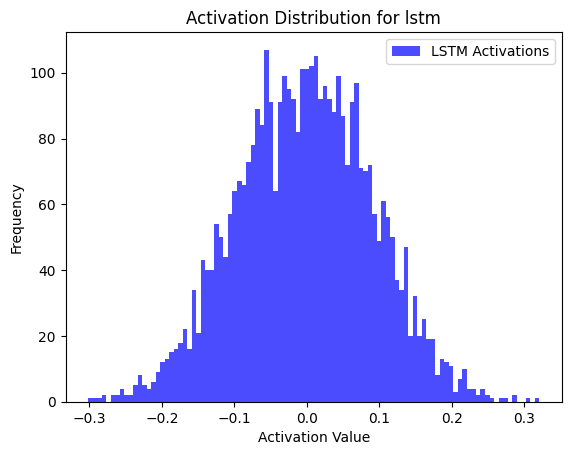

Gradient for fc layer:  torch.Size([3, 5, 5000])


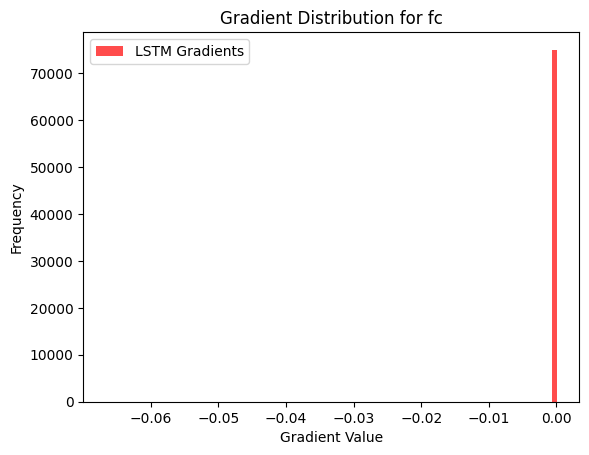

In [14]:

# After training, you can analyze the activations and gradients
# Example: Plot the activations of the LSTM layer
layer_name, activation = activations[0]  # Assuming lstm activation
print(f"Activation for {layer_name} layer: ", activation)

# Plotting histogram of activations of the LSTM layer
plt.hist(activation[0].detach().numpy().flatten(), bins=100, alpha=0.7, color='b', label='LSTM Activations')
plt.title(f"Activation Distribution for {layer_name}")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Example: Plot the gradients of the LSTM layer
layer_name, grad = gradients[0]  # Assuming lstm gradient
print(f"Gradient for {layer_name} layer: ", grad[0].shape)

# Plotting histogram of gradients of the LSTM layer
plt.hist(grad[0].numpy().flatten(), bins=100, alpha=0.7, color='r', label='LSTM Gradients')
plt.title(f"Gradient Distribution for {layer_name}")
plt.xlabel("Gradient Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Activation for fc layer:  torch.Size([3, 5, 5000])


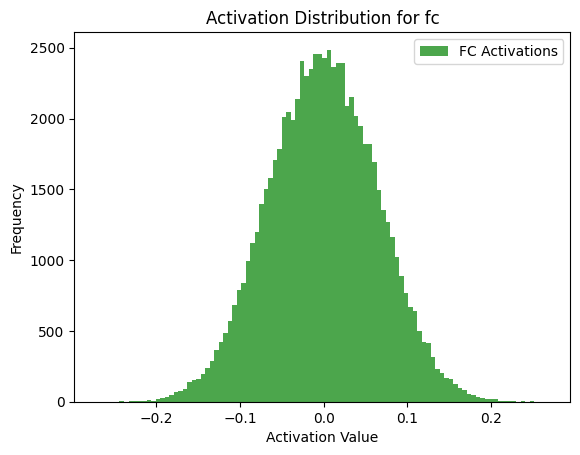

Gradient for lstm layer:  torch.Size([3, 5, 256])


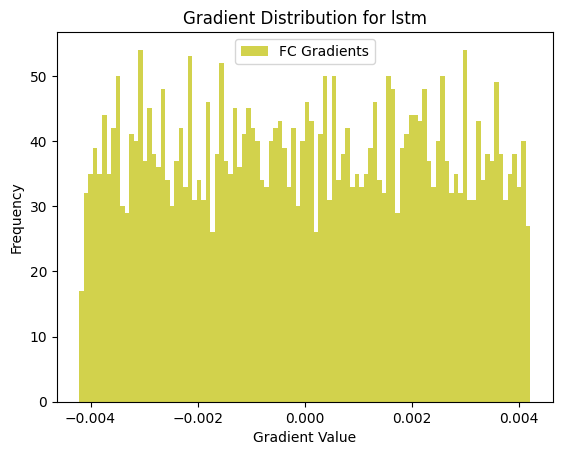

In [17]:

# Example: Plot the activations of the final Linear layer
layer_name, activation = activations[1]  # Assuming fc activation
print(f"Activation for {layer_name} layer: ", activation.shape)

# Plotting histogram of activations of the final Linear layer
plt.hist(activation.detach().numpy().flatten(), bins=100, alpha=0.7, color='g', label='FC Activations')
plt.title(f"Activation Distribution for {layer_name}")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Example: Plot the gradients of the final Linear layer
layer_name, grad = gradients[1]  # Assuming fc gradient
print(f"Gradient for {layer_name} layer: ", grad[0].shape)

# Plotting histogram of gradients of the final Linear layer
plt.hist(grad[0].numpy().flatten(), bins=100, alpha=0.7, color='y', label='FC Gradients')
plt.title(f"Gradient Distribution for {layer_name}")
plt.xlabel("Gradient Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()
